##Sympy
---
Sympy is a python libraries prrmarily designed for symbolic calculation (and other things). Let us show that how we can use it to simply our calculation for logistic functions. 

In [1]:
!pip install sympy

In [3]:
from sympy import *
init_printing(use_unicode=True)

In [4]:
x = symbols('x')

In [5]:
def sigma(x):
    return 1/(1 + exp(-x))

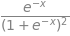

In [6]:
diff(sigma(x), x)

In [7]:
def log_lik(t):
    return log(sigma(t))
def log_lik_minus(t):
    return log(1-sigma(t))

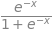

In [8]:
diff(log_lik(x),x)

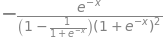

In [12]:
diff(log_lik_minus(x), x)

The results above are ugly. Let us try to simplify it using `simplify` function.

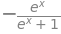

In [10]:
simplify(diff(log_lik_minus(x), x))

Let us use sympy to simplify certain notations. Pay attention that we have used $m$ to replace the $x_i^t\beta$ part in the lecture notes. 

In [13]:
 m, y = symbols('m y')
 def my_expression(m, y):
     return y * (exp(-m)/(1+exp(-m))) - (1-y)*(exp(m)/(1+exp(m)))

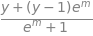

In [14]:
simplify(my_expression(m, y))

## Jax time

Now let us try to use Jax to derive a useful version of optimize routine. 

In [15]:
!pip install jax jaxlib

In [20]:
import jax 
from jax import lax
from jax import random
import jax.numpy as jnp

In [21]:
# Question: Why define it like this
def sigmoid(x):
    return 0.5 * (jnp.tanh(x / 2) + 1)

In [38]:
key = random.PRNGKey(0)
x_key, beta_key, beta_test_key = random.split(key,3)
x = random.normal(x_key, (10000, 10))
beta = random.normal(beta_key, (10,))*2.0
beta_test = random.normal(beta_test_key, (10,))
y = (sigmoid(x.dot(beta))>=0.5).astype(jnp.float32)

In [39]:
y.sum() # Check whether the results are reasonable

DeviceArray(5017., dtype=float32)

In [40]:
def predict(beta, x):
    return sigmoid(x.dot(beta))

def loss(beta):
    preds = predict(beta,x)
    label_probs = preds * y + (1 - preds) * (1 - y)
    return -jnp.sum(jnp.log(label_probs))/10000.00 

In [41]:
loss(beta)

DeviceArray(0.11576848, dtype=float32)

In [42]:
grad_func = jax.grad(loss)
grad_func(beta)

DeviceArray([ 0.00455572,  0.01565121, -0.00860528, -0.00485265,
              0.00207953, -0.00256935,  0.00626605, -0.00537516,
              0.0021444 , -0.00108901], dtype=float32)

In [43]:
jax.grad(loss)(beta_test)

DeviceArray([ 0.24341543,  0.29687792, -0.02719578, -0.13187405,
             -0.05313726, -0.11881255,  0.15694779,  0.10492595,
             -0.05401438, -0.0366895 ], dtype=float32)

# Question: What can We See from This Implementation?

The derivatives should be close to $0$. Because we are evaluating it at the true function. It should never be equal to $0$ because we generally never have unlimited sample for that, however, it should not be too huge as well. 

Also, it should in general be different from, say, a randomly initialized beta. 

Now let us try to make our own implementation of the grad function. It should be close to what autograd gives us. 

What we have derived is that the gradient is \begin{align*}
-\sum_i (y_i - \sigma(x_i^t\beta) )x_i 
\end{align*}

This isn't the most convenint form for implementation, thanks to the pesky summation. 

# Question: How Can we Simplify the Above Expression?

In [44]:
# Why this makes sense?
def custom_grad(beta):
    residual = y - predict(beta, x)
    return jnp.transpose(x).dot(-residual)/10000.00

In [45]:
custom_grad(beta)

DeviceArray([ 0.00455572,  0.01565119, -0.00860529, -0.00485265,
              0.00207953, -0.00256935,  0.00626604, -0.00537516,
              0.00214439, -0.00108901], dtype=float32)

In [ ]:
custom_grad(beta_test)

DeviceArray([ 0.24341445,  0.29687792, -0.02719574, -0.13187398,
             -0.0531371 , -0.1188125 ,  0.15694797,  0.10492576,
             -0.05401447, -0.03668943], dtype=float32)

## Proximal methods implementation.
---

Here we implement the proximal methods and see whether it will lead to the desired outcome. 

In [46]:
def soft_threshold(x, thres):
    return jax.lax.cond(x > thres,
                        lambda _: x - thres,
                        lambda _: jax.lax.cond(
                            x < -thres,
                            lambda _: x + thres,
                            lambda _:0.0,
                            None
                        ),
                        None)

In [ ]:
def proximal_methods(beta_init, max_iter, eps, lr, penalty):
    converged = False
    beta_old = beta_init
    beta_new = beta_init
    soft_threshold_partial = lambda x: soft_threshold(x, lr*penalty)
    current_iter = 0
    while not converged and current_iter < max_iter:
        print("Current iteration is %d"% current_iter)
        beta_copy = beta_old 
        current_loss = loss(beta_copy) + penalty*jnp.linalg.norm(beta_copy, 1)
        current_grad = custom_grad(beta_copy)
        w = beta_copy - lr*current_grad
        beta_new = jax.vmap(soft_threshold_partial, 0)(w)
        new_loss = loss(beta_new) + penalty*jnp.linalg.norm(beta_new, 1)
        diff = jnp.abs(new_loss-current_loss)
        print("The difference is %.5f"%diff)
        beta_old = beta_new
        if diff <= eps:   
            converged = True
            print("Algorithm converged")
            break
        else:
            current_iter +=1
            if current_iter >= max_iter:
                print("The algorithm have failed to converge.")
                break

    return beta_new, converged

In [ ]:
key = random.PRNGKey(0)
x_key, beta_init_key = random.split(key,2)
x = random.normal(x_key, (10000, 5))
beta = jnp.array([2.0,2.0,0.0,0.0,0.0])
beta_init = random.normal(beta_init_key, (5,))
y = (sigmoid(x.dot(beta))>=0.5).astype(jnp.float32)

Before we run the whole function, it is better to evaluate using a step-by-step approach to see where it might go wrong.

In [ ]:
lr = 0.1
penalty = 1.0
eps = 1e-5

In [ ]:
converged = False
beta_old = beta_init
beta_new = beta_init
soft_threshold_partial = lambda x: soft_threshold(x, lr*penalty)
current_iter = 0

In [ ]:
beta_copy = beta_old 
current_loss = loss(beta_copy) 
current_grad = custom_grad(beta_copy)

In [ ]:
current_loss + penalty * jnp.linalg.norm(beta_copy,1)

DeviceArray(10.273039, dtype=float32)

In [ ]:
beta_copy

DeviceArray([-1.4581941, -2.0470448,  2.0473385,  1.1684095, -0.9758365],            dtype=float32)

In [ ]:
w = beta_copy - lr*current_grad

In [ ]:
w

DeviceArray([-1.4146639 , -1.9989496 ,  2.0274482 ,  1.1572018 ,
             -0.96532995], dtype=float32)

In [ ]:
beta_new = jax.vmap(soft_threshold_partial, 0)(w)

In [ ]:
beta_new

DeviceArray([-1.3146639, -1.8989496,  1.9274482,  1.0572017, -0.8653299],            dtype=float32)

In [ ]:
new_loss = loss(beta_new) + penalty*jnp.linalg.norm(beta_new, 1)

In [ ]:
new_loss

DeviceArray(9.459178, dtype=float32)

The above results seem reasonable, now let us test what happens near the optimal beta

In [ ]:
_, noise_key = random.split(beta_init_key)
noise = random.normal(noise_key, (5,))*0.01

In [ ]:
beta_init = beta + noise

In [ ]:
beta_init

DeviceArray([ 1.9979278e+00,  1.9895447e+00,  2.4958886e-02,
              2.7045694e-03, -1.0351079e-04], dtype=float32)

In [ ]:
converged = False
beta_old = beta_init
beta_new = beta_init
soft_threshold_partial = lambda x: soft_threshold(x, lr*penalty)
current_iter = 0

In [ ]:
beta_copy = beta_old 
current_loss = loss(beta_copy) 
current_grad = custom_grad(beta_copy)

In [ ]:
current_loss + penalty * jnp.linalg.norm(beta_copy,1)

DeviceArray(4.2238173, dtype=float32)

In [ ]:
w = beta_copy - lr*current_grad

In [ ]:
beta_new = jax.vmap(soft_threshold_partial, 0)(w)

In [ ]:
beta_new

DeviceArray([1.9023663, 1.893549 , 0.       , 0.       , 0.       ], dtype=float32)

That seems right as well! Now to plug in everything and see how to goes. First we still start with the easy one.

In [ ]:
def proximal_methods(beta_init, max_iter, eps, lr, penalty):
    converged = False
    beta_old = beta_init
    beta_new = beta_init
    soft_threshold_partial = lambda x: soft_threshold(x, lr*penalty)
    current_iter = 0
    new_loss = 100000
    while not converged and current_iter < max_iter:
        print("Current iteration is %d"% current_iter)
        beta_copy = beta_old 
        current_loss = loss(beta_copy) + penalty*jnp.linalg.norm(beta_copy, 1)
        current_grad = custom_grad(beta_copy)
        w = beta_copy - lr*current_grad
        beta_new = jax.vmap(soft_threshold_partial, 0)(w)
        new_loss = loss(beta_new) + penalty*jnp.linalg.norm(beta_new, 1)
        diff = jnp.abs(new_loss-current_loss)
        print("The difference is %.5f"%diff)
        beta_old = beta_new
        if diff <= eps:   
            converged = True
            print("Algorithm converged")
            break
        else:
            current_iter +=1
            if current_iter >= max_iter:
                print("The algorithm have failed to converge.")
                break

    return beta_new, new_loss, converged

In [ ]:
max_iter = 1000
eps = 1e-4
lr = 0.05
penalty = 0.1# This can be only done via trial and error

In [ ]:
key = random.PRNGKey(0)
x_key, beta_init_key = random.split(key,2)
x = random.normal(x_key, (10000, 5))
beta = jnp.array([2.0,2.0,0.0,0.0,0.0])
beta_init = beta+ random.normal(beta_init_key, (5,))*0.01
y = (sigmoid(x.dot(beta))>=0.5).astype(jnp.float32)

In [ ]:
beta_sol, new_loss, converged = proximal_methods(beta_init, max_iter, eps, lr, penalty)

Current iteration is 0
The difference is 0.00184
Current iteration is 1
The difference is 0.00181
Current iteration is 2
The difference is 0.00100
Current iteration is 3
The difference is 0.00083
Current iteration is 4
The difference is 0.00035
Current iteration is 5
The difference is 0.00032
Current iteration is 6
The difference is 0.00032
Current iteration is 7
The difference is 0.00032
Current iteration is 8
The difference is 0.00032
Current iteration is 9
The difference is 0.00032
Current iteration is 10
The difference is 0.00032
Current iteration is 11
The difference is 0.00032
Current iteration is 12
The difference is 0.00032
Current iteration is 13
The difference is 0.00032
Current iteration is 14
The difference is 0.00032
Current iteration is 15
The difference is 0.00031
Current iteration is 16
The difference is 0.00031
Current iteration is 17
The difference is 0.00031
Current iteration is 18
The difference is 0.00031
Current iteration is 19
The difference is 0.00031
Current it

In [ ]:
beta_sol

DeviceArray([1.4203815, 1.3840511, 0.       , 0.       , 0.       ], dtype=float32)

In [ ]:
new_loss

DeviceArray(0.55273294, dtype=float32)

Now for the real test

In [ ]:
key = random.PRNGKey(0)
x_key, beta_init_key = random.split(key,2)
x = random.normal(x_key, (10000, 5))
beta = jnp.array([2.0,2.0,0.0,0.0,0.0])
beta_init = random.normal(beta_init_key, (5,)) # This time beta_init is totally stochastic
y = (sigmoid(x.dot(beta))>=0.5).astype(jnp.float32)

In [ ]:
max_iter = 1000
eps = 1e-4
lr = 0.05
penalty = 0.1 # This can be only done via trial and error

In [ ]:
beta_sol, new_loss, converged = proximal_methods(beta_init, max_iter, eps, lr, penalty)

Current iteration is 0
The difference is 0.03999
Current iteration is 1
The difference is 0.03988
Current iteration is 2
The difference is 0.03977
Current iteration is 3
The difference is 0.03964
Current iteration is 4
The difference is 0.03953
Current iteration is 5
The difference is 0.03940
Current iteration is 6
The difference is 0.03928
Current iteration is 7
The difference is 0.03915
Current iteration is 8
The difference is 0.03901
Current iteration is 9
The difference is 0.03888
Current iteration is 10
The difference is 0.03874
Current iteration is 11
The difference is 0.03860
Current iteration is 12
The difference is 0.03845
Current iteration is 13
The difference is 0.03830
Current iteration is 14
The difference is 0.03814
Current iteration is 15
The difference is 0.03799
Current iteration is 16
The difference is 0.03783
Current iteration is 17
The difference is 0.03767
Current iteration is 18
The difference is 0.03750
Current iteration is 19
The difference is 0.03732
Current it

In [ ]:
beta_sol

DeviceArray([0.7655314 , 0.70897543, 0.        , 0.        , 0.        ],            dtype=float32)

In [ ]:
new_loss

DeviceArray(0.54692423, dtype=float32)

As you can see, it is usually not the case that you will get any good results considering that everything does not have to work so well in the numerical sense. As you can see, if we start from the real value we may end up somewhere else. In fact, it is perfectly reasonable to assume in the first situation, the algorithm has not converged at all, since a better solution is found in the second instance. 

**Exercise: 1** There is an improved version of line search in lasso.pdf. Try to implement it and see if it helps.

**Exercise: 2** One way to alleviate the problem is by giving a better init function. Usually it is a little bit cheating to assume we have already a logistic regression function, so try a linear regression function and see what happens. 

**Exercise: 3 (Difficult)** Try to print out everything and see what might go wrong in the algorithm and see one can improve there. Note that without the soft threshold, what we have just implemented is basically a simple gradient decent which can be pretty bad. Is there anyway to improve it?

